True values: -0.14896398423444102
Value estimates: [-0.5        -0.77777778 -1.         -1.          0.99919404]
Action counts: [  14.    9.    7.    7. 4963.]
True values: -0.21942439328931207
Value estimates: [-0.875      -0.63636364 -0.77777778 -1.          0.99919436]
Action counts: [   8.   11.    9.    7. 4965.]
True values: -0.7789064204021984
Value estimates: [-0.875      -0.77777778 -1.         -1.          0.99879251]
Action counts: [   8.    9.    7.    7. 4969.]
True values: -0.49528731469518283
Value estimates: [-0.5        -0.77777778 -1.         -1.          0.99959702]
Action counts: [  14.    9.    7.    7. 4963.]


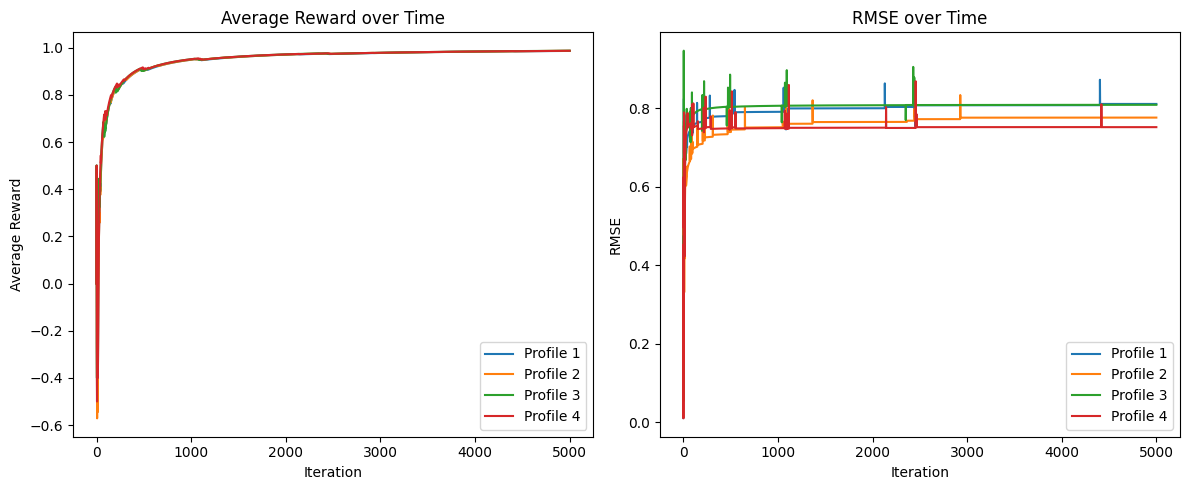

In [2]:
import numpy as np
import tensorflow as tf
import tf_agents.environments as tf_env
import tf_agents.specs as tf_specs
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import trajectory

class FiveArmedBanditEnv(tf_env.py_environment.PyEnvironment):
    def __init__(self, user_model_vec, change_probability=[], lambda_fatigue=0.01, seed=42):
        self._num_actions = 5
        self._user_model_vec = user_model_vec
        self._change_probability = change_probability
        self._lambda_fatigue = lambda_fatigue
        self._step_count = 0
        self._total_reward = 0.0
        self._dummy_observation = np.array([0.0, 0.0, 0.0, 0.0, 0.0], dtype=np.float32)
        np.random.seed(seed)
        super(FiveArmedBanditEnv, self).__init__()

    def action_spec(self):
        return tf_specs.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=self._num_actions - 1, name='action')

    def observation_spec(self):
        return tf_specs.BoundedArraySpec(
            shape=(self._num_actions,), dtype=np.float32, minimum=0, name='observation')

    def _reset(self):
        self._step_count = 0
        self._total_reward = 0.0
        return ts.restart(observation=self._dummy_observation)
    
    def _step(self, action):
        fatigue = 1 - np.exp(-self._lambda_fatigue * self._step_count)
        adjusted_change_probability = self._change_probability[action] * (1 - fatigue)

        if np.random.uniform(0, 1) < adjusted_change_probability:
            self.current_state = 'changed_posture'
        else:
            self.current_state = 'same_posture'

        # Define rewards based on the state and action
        if self.current_state == 'changed_posture':
            reward = 1 if action != 4 else -1  # Positive reward for any action except 'stay'
        else:
            reward = -1 if action != 4 else 1  # Negative reward for any action except 'stay'

        self._step_count += 1
        self._total_reward += reward

        return ts.transition(observation=self._dummy_observation, reward=reward)
    
    def get_total_reward(self):
        return self._total_reward

    def get_step_count(self):
        return self._step_count


def generate_user_profiles(num_profiles, base_change_probability_range, lambda_fatigue_range):
    user_profiles = []
    for _ in range(4):
        # Randomly sample 5 probabilities and put them in a list
        

        base_change_probability = [np.random.uniform(*base_change_probability_range), np.random.uniform(*base_change_probability_range), np.random.uniform(*base_change_probability_range), np.random.uniform(*base_change_probability_range), np.random.uniform(*base_change_probability_range)]
        lambda_fatigue = np.random.uniform(*lambda_fatigue_range)
        user_profiles.append((base_change_probability, lambda_fatigue))
    return user_profiles

class UCB1Agent:
    def __init__(self, num_actions, explore_rate=2.0):
        self.num_actions = num_actions
        self.explore_rate = explore_rate
        self.action_counts = np.zeros(num_actions)
        self.action_values = np.zeros(num_actions)
        self.total_steps = 0

    def select_action(self):
        ucb_values = self.action_values + self.explore_rate * np.sqrt(np.log(self.total_steps + 1) / (self.action_counts + 1))
        return np.argmax(ucb_values)

    def update_estimates(self, action, reward):
        self.total_steps += 1
        self.action_counts[action] += 1
        alpha = 1 / self.action_counts[action]
        self.action_values[action] += alpha * (reward - self.action_values[action])

    def get_current_average_reward(self):
        return np.sum(self.action_values * self.action_counts) / np.sum(self.action_counts)

class SARSA:
    def __init__(self, num_actions, lr=0.1, gamma=0.9):
        self.num_actions = num_actions
        self.lr = lr
        self.gamma = gamma
        self.action_values = np.zeros(num_actions)
        self.total_steps = 0

    def select_action(self, observation):
        return np.argmax(self.action_values)

    def update(self, observation, action, reward, next_observation, next_action):
        td_target = reward + self.gamma * self.action_values[next_action]
        td_error = td_target - self.action_values[action]
        self.action_values[action] += self.lr * td_error

class LinearFunctionApproximation:
    def __init__(self, num_actions, lr=0.1, gamma=0.9, state_dim=5):
        self.num_actions = num_actions
        self.lr = lr
        self.gamma = gamma
        self.state_dim = state_dim
        self.weights = np.zeros((num_actions, state_dim))
        self.total_steps = 0

    def select_action(self, observation):
        q_values = np.dot(self.weights, observation)
        return np.argmax(q_values)

    def update(self, observation, action, reward, next_observation, next_action):
        q_value = np.dot(self.weights[action], observation)
        td_target = reward + self.gamma * np.dot(self.weights[next_action], next_observation)
        td_error = td_target - q_value
        self.weights[action] += self.lr * td_error * observation

def user_simulation_UCB1(user_profiles, num_iterations=5000, explore_rate=2.0):
    all_average_rewards = []
    all_rmse = []

    for base_change_probability, lambda_fatigue in user_profiles:
        # Create the environment
        env = FiveArmedBanditEnv(user_model_vec=None, change_probability=base_change_probability, lambda_fatigue=lambda_fatigue)

        # Create the UCB1 agent
        agent = UCB1Agent(num_actions=env.action_spec().maximum + 1, explore_rate=explore_rate)

        average_rewards = []
        rmse = []

        # Training loop
        for _ in range(num_iterations):
            # Main stepping
            action = agent.select_action()
            time_step = env.step(action)
            agent.update_estimates(action, time_step.reward)

            # Logs for plotting
            average_rewards.append(agent.get_current_average_reward())
            true_action_value = 2 * base_change_probability[action] - 1
            rmse.append(np.sqrt(np.mean((np.subtract(agent.action_values, true_action_value))**2)))

        all_average_rewards.append(average_rewards)
        all_rmse.append(rmse)

        print("True values: {}".format(true_action_value))
        print("Value estimates: {}".format(agent.action_values))
        print("Action counts: {}".format(agent.action_counts))

    return all_average_rewards, all_rmse

# def user_simulation_SARSA(user_profiles, num_iterations=500, lr=0.1, gamma=0.9):
#     all_average_rewards = []
#     all_rmse = []

#     for base_change_probability, lambda_fatigue in user_profiles:
#         # Create the environment
#         env = FiveArmedBanditEnv(user_model_vec=None, change_probability=base_change_probability)
#         agent = SARSA(num_actions=env.action_spec().maximum + 1, lr=lr, gamma=gamma)
        
#         average_rewards = []
#         rmse = []

        # # Training loop
        # for _ in range(num_iterations):
        #     # Reset the environment at the start of each iteration
        #     time_step = env.reset()

        #     # Main stepping
        #     action = agent.select_action(time_step.observation)
        #     next_time_step = env.step(action)
        #     next_action = agent.select_action(next_time_step.observation)
        #     agent.update(
        #         observation=time_step.observation,
        #         action=action,
        #         reward=next_time_step.reward,
        #         next_observation=next_time_step.observation,
        #         next_action=next_action
        #     )

        #     # Logs for plotting
        #     average_rewards.append(env.get_total_reward() / env.get_step_count())
        #     true_action_value = 2 * base_change_probability - 1
#             rmse.append(np.sqrt(np.mean((np.subtract(agent.action_values, true_action_value))**2)))

#         all_average_rewards.append(average_rewards)
#         all_rmse.append(rmse)

#         print(f"User profile with base change probability {base_change_probability:.2f} and lambda fatigue {lambda_fatigue:.2f}")
#         print("True values: {}".format(true_action_value))
#         print("Value estimates: {}".format(agent.action_values))
#         print("Action counts: N/A (SARSA agent does not keep track of action counts)")

#     return all_average_rewards, all_rmse

# def user_simulation_LFA(user_profiles, num_iterations=500, lr=0.1, gamma=0.9):
#     all_average_rewards = []
#     all_rmse = []

#     for base_change_probability, lambda_fatigue in user_profiles:
#         # Create the environment
#         env = FiveArmedBanditEnv(user_model_vec=None, change_probability=base_change_probability)

#         agent = LinearFunctionApproximation(num_actions=env.action_spec().maximum + 1, lr=lr, gamma=gamma)

#         average_rewards = []
#         rmse = []

#         # Training loop
#         for _ in range(num_iterations):
#             # Main stepping
#             time_step = env.reset()
#             action = agent.select_action(time_step.observation)
#             next_time_step = env.step(action)
#             next_action = agent.select_action(next_time_step.observation)
#             agent.update(
#                 observation=env.current_time_step().observation,
#                 action=action,
#                 reward=time_step.reward,
#                 next_observation=time_step.observation,
#                 next_action=next_action
#             )

#             # Logs for plotting
#             average_rewards.append(env.get_total_reward() / env.get_step_count())
#             true_action_value = 2 * base_change_probability - 1
#             rmse.append(np.sqrt(np.mean((np.subtract(agent.action_values, true_action_value))**2)))

#         all_average_rewards.append(average_rewards)
#         all_rmse.append(rmse)

#         print(f"User profile with base change probability {base_change_probability:.2f} and lambda fatigue {lambda_fatigue:.2f}")
#         print("True values: {}".format(true_action_value))
#         print("Value estimates: {}".format(agent.action_values))
#         print("Action counts: N/A (LFA agent does not keep track of action counts)")
#     return all_average_rewards, all_rmse

if __name__ == "__main__":
    num_profiles = 30 # We want enough profiles to see the variance in the results but not too many to stay feasible in the real experiment
    base_change_probability_range = (0.1, 0.5) # At minimum, the user changes posture 10% of the time and at maximum 50% of the time
    lambda_fatigue_range = (0.005, 0.1) # In the paper the values chosen were 0.01, 0.03 and 0.05
    
    # UCB1
    user_profiles = generate_user_profiles(num_profiles, base_change_probability_range, lambda_fatigue_range)
    average_rewards, rmse = user_simulation_UCB1(user_profiles)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))

    for i, (avg_rewards, rms) in enumerate(zip(average_rewards, rmse)):
        plt.subplot(1, 2, 1)
        plt.plot(avg_rewards, label=f'Profile {i+1}')
        plt.xlabel('Iteration')
        plt.ylabel('Average Reward')
        plt.title('Average Reward over Time')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(rms, label=f'Profile {i+1}')
        plt.xlabel('Iteration')
        plt.ylabel('RMSE')
        plt.title('RMSE over Time')
        plt.legend()

    plt.tight_layout()
    plt.show()


    # # SARSA
    # user_profiles = generate_user_profiles(num_profiles, base_change_probability_range, lambda_fatigue_range)
    # average_rewards, rmse = user_simulation_SARSA(user_profiles)

    # import matplotlib.pyplot as plt
    # plt.figure(figsize=(12, 5))

    # for i, (avg_rewards, rms) in enumerate(zip(average_rewards, rmse)):
    #     plt.subplot(1, 2, 1)
    #     plt.plot(avg_rewards, label=f'Profile {i+1}')
    #     plt.xlabel('Iteration')
    #     plt.ylabel('Average Reward')
    #     plt.title('Average Reward over Time')
    #     plt.legend()

    #     plt.subplot(1, 2, 2)
    #     plt.plot(rms, label=f'Profile {i+1}')
    #     plt.xlabel('Iteration')
    #     plt.ylabel('RMSE')
    #     plt.title('RMSE over Time')
    #     plt.legend()

    # plt.tight_layout()
    # plt.show()

    # # LFA
    # user_profiles = generate_user_profiles(num_profiles, base_change_probability_range, lambda_fatigue_range)
    # average_rewards, rmse = user_simulation_LFA(user_profiles)

    # import matplotlib.pyplot as plt
    # plt.figure(figsize=(12, 5))

    # for i, (avg_rewards, rms) in enumerate(zip(average_rewards, rmse)):
    #     plt.subplot(1, 2, 1)
    #     plt.plot(avg_rewards, label=f'Profile {i+1}')
    #     plt.xlabel('Iteration')
    #     plt.ylabel('Average Reward')
    #     plt.title('Average Reward over Time')
    #     plt.legend()

    #     plt.subplot(1, 2, 2)
    #     plt.plot(rms, label=f'Profile {i+1}')
    #     plt.xlabel('Iteration')
    #     plt.ylabel('RMSE')
    #     plt.title('RMSE over Time')
    #     plt.legend()

    # plt.tight_layout()
    # plt.show()
